# 시계열 데이터 분석(정석)
- ACF plot과 PACF plot을 통해 모수를 추정하여 차분을 수행하여 분석하는 방법
- ACF (Autocorrelation Function)
- PACF (Partial Autocorrelation Function)
## 1. 작업 준비
### 패키지 및 데이터 가져오기
- `pmdarima` 패키지 설치 필요
- 이미 앞 예제를 통해 데이터가 비정상성임을 확인함 (2_시계열데이터확인)

In [1]:
from pandas import read_excel
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import statsmodels.api as sm   # plot_acf랑 plot_pacf를 subplot에 넣기 위한 모듈
import seaborn as sb
import sys

In [21]:
df = read_excel('https://data.hossam.kr/E06/air_passengers.xlsx')
df

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


## 2. 데이터의 정상성 확인
### 1) 데이터 시각화를 통한 정상성 확인

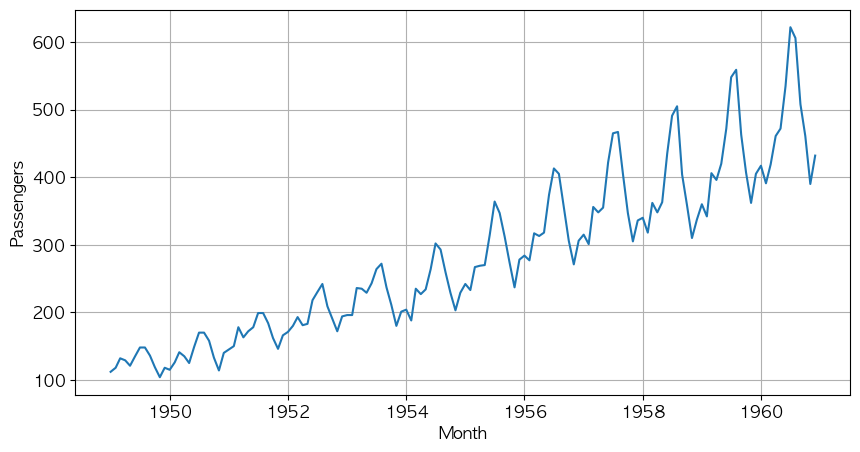

In [3]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

plt.figure()
sb.lineplot(data=df, x='Month', y='Passengers')
plt.grid()
plt.show()
plt.close()

> 데이터의 패턴은 보이지만 시간이 지날수록 증폭의 정도가 심해지는 것을 보아(=일정하지 않음) `비정상성`임을 알 수 있다.

### 2) 원본 데이터에 대한 `ADF` 테스트

#### ADF 테스트의 가설
|가설|내용|
|--|--|
|귀무가설|데이터가 정상성과 다르다(=비정상성임을 의미)|
|대립가설|데이터가 정상성이다|

- 여기서 우리가 봐야할 것은 `p-value`이다
    - `p-value` > 0.05: `비정상성 데이터`로 간주 -> `차분을 1회 수행`하고 다시 ADF 검정을 수행
        - 대립가설이 채택될 때까지 이 과정을 반복함
        - `반복 횟수`(차분 한 횟수)가 $d$ 값이 됨
    - `p-value` < 0.05: `정상성 데이터`로 간주 -> 차분을 더 수행하지 않아도 됨

In [26]:
ar = adfuller(df['Passengers'])
print(ar)
print('ADF Statistic: %f' % ar[0])
print('p-value: %f' % ar[1])
print('num of lags: %f' % ar[2])
print('num of observations: %f' % ar[3])
print('Critical Values: ')
for key, value in ar[4].items():
    print('\t%s: %.3f' % (key, value))

(0.8153688792060447, 0.9918802434376409, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)
ADF Statistic: 0.815369
p-value: 0.991880
num of lags: 13.000000
num of observations: 130.000000
Critical Values: 
	1%: -3.482
	5%: -2.884
	10%: -2.579


> `p-value가 0.05보다 크므로` `비정상성`임을 알 수 있다.
>
> 그러므로 `차분 수행`

### 3) 1차 차분 수행 및 시각화
- 차분 방법: `데이터프레임.diff()`
- 날짜 데이터는 평균을 낼 수 없기에 실 데이터(승객 수)만으로 차분을 수행해야 함
- 빈값이 있으면 차분할 수 없기에 `.dropna()`로 빈값 제거?

1       6.0
2      14.0
3      -3.0
4      -8.0
5      14.0
       ... 
139   -16.0
140   -98.0
141   -47.0
142   -71.0
143    42.0
Name: Passengers, Length: 143, dtype: float64


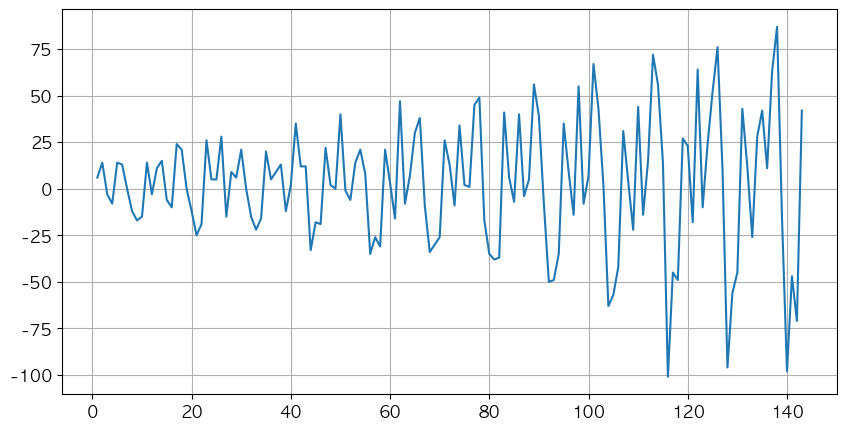

In [27]:
# 수행
diff = df['Passengers'].diff().dropna()
print(diff)

# 시각화
plt.figure()
sb.lineplot(x=diff.index, y=diff.values)
plt.grid()
plt.show()
plt.close()

> 차분 결과 시각화:
>
> 평균은 0으로 일정해 지는 것으로 보이나 뒤로 갈수록 점점 간격이 커지는 것으로 보아 아직 `분산은 일정하지 않은 것`으로 여겨짐
> 즉, 아직은 정상성을 갖는다고 보기 어려움

### 4) 차분 결과에 대한 ADF 테스트

In [28]:
ar_diff1 = adfuller(diff.values)

print('ADF Statistic for ar_diff1: %f' % ar_diff1[0])
print('p-value for ar_diff1: %f' % ar_diff1[1])
print('num of lags for ar_diff1: %f' % ar_diff1[2])
print('num of observations for ar_diff1: %f' % ar_diff1[3])
print('Critical Values for ar_diff1:')
for key, value in ar_diff1[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for ar_diff1: -2.829267
p-value for ar_diff1: 0.054213
num of lags for ar_diff1: 12.000000
num of observations for ar_diff1: 130.000000
Critical Values for ar_diff1:
	1%: -3.482
	5%: -2.884
	10%: -2.579


> $p-value$가 아직은 `0.05보다 크므로 정상성을 만족하지 않지만` 1회 정도 추가로 차분을 수행하면 정상성 데이터로 변환이 가능할 것으로 예상됨 (여기서부터는 생략 - ARIMA할 것이므로)

## 3. ACF, PACF 검정

- 정상 시계열 데이터의 경우, ACF는 상대적으로 빠르게 0(상관관계 0)에 접근한다.
- 비정상 시계열 데이터의 경우, ACF는 천천히 감소하며 종종 큰 양의 값을 갖는다.

|구분|$AR(p)$ 모델 적합|$MA(q)$ 모델 적합|
|--|--|--|
|ACF plot|천천히 감소|첫 값으로부터 $q$개 뒤에 끊긴다|
|PACF plot|첫 값으로부터 $p$개 뒤에 끊긴다|천천히 감소|

### 1) ACF Plot & PACF Plot
- `plot_acf(컬럼)`
- `plot_pacf(컬럼)`

- subplot에 담기 위한 함수: 
    - `statsmodels.api.graphics.tsa.plot_acf()`
    - `statsmodels.api.graphics.tsa.plot_pacf()`

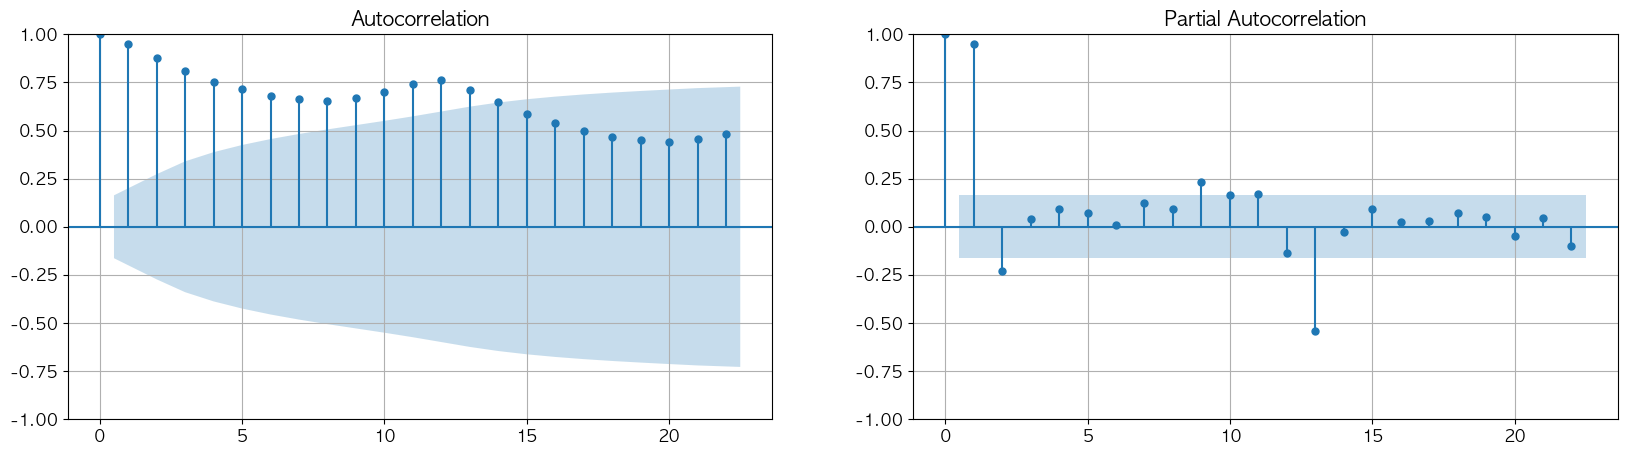

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(20, 5))
sm.graphics.tsa.plot_acf(df['Passengers'], ax=ax1)    # ACF Plot
ax1.grid()
sm.graphics.tsa.plot_pacf(df['Passengers'], ax=ax2)   # PACF Plot
ax2.grid()
plt.show()
plt.close()

- ACF, PACF Plot으로 적용할 모델을 결정하려면 차분을 몇 번 수행하는 것이 좋을지 결정해야 함

|모델|의미|
|--|--|
|$AR(n)$|$ARIMA(p, d, q)$ 중에서 $p=n, q=0$ 이라는 의미|
|$MA(n)$|$ARIMA(p, d, q)$ 중에서 $p=0, q=n$ 이라는 의미|

- ADF 테스트의 결과로 `차분의 횟수`가 결정되면 이 값이 `d`를 의미함

#### 결과 판정
> |구분|ACF plot|PACF plot|
> |--|--|--|
> |감소|상대적으로 완만|상대적으로 급격|
> |파란박스 진입 지점|$p = 1$|$q = 1$|
>
> 이 결과를 고려하여 완만함을 보이는 `ACF 플롯`, `AR(1) 모델`로 결정
- 완만하다는 기준: 동그라미들이 거의 일직선으로 가면 "완만하다"고 말함


## 4. ARIMA 분석 수행
- model.fit()의 파라미터
    - transformed: Whether or not start_params is already transformed. Default is True
        - 예) fit = model.fit(transformed = False)
### 1) ARIMA 분석
- `ARIMA(컬럼, order =(p, d, q))`
    - order = (p,d,f) 파라미터는 앞에 검정 결과에 따른 값
    - 이 예제에서는 AR(1) 모델로 결정했으므로:
        - p값 = 1 (파란박스 진입 지점)
        - d값 = 1 (차분 수행 횟수)
        - q값 = 0 (모든 AR(n)모델은 q값이 0이다?)

In [32]:
model = ARIMA(df['Passengers'], order =(1, 1, 0))
fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -698.926
Date:                Thu, 03 Aug 2023   AIC                           1401.852
Time:                        15:16:12   BIC                           1407.778
Sample:                             0   HQIC                          1404.260
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3066      0.080      3.849      0.000       0.150       0.463
sigma2      1029.2429    103.738      9.922      0.000     825.920    1232.566
Ljung-Box (L1) (Q):                   0.66   Jarque-

### 2) 학습 결과에 대한 예측값 생성

In [33]:
start_index = 0
end_index = len(df['Passengers'])
pd = fit.predict(start=start_index, end=end_index)
pd

0        0.000000
1      112.038959
2      119.839303
3      136.291707
4      128.080349
          ...    
140    601.095192
141    477.958052
142    446.592127
143    368.234915
144    444.875121
Name: predicted_mean, Length: 145, dtype: float64

### 3) 이후 10 단계의 예측값 생성

In [35]:
fc = fit.forecast(10)
fc

144    444.875121
145    448.821995
146    450.031912
147    450.402812
148    450.516512
149    450.551367
150    450.562051
151    450.565327
152    450.566331
153    450.566639
Name: predicted_mean, dtype: float64

### 4) 관측치와 예측치의 비교 결과 시각화

['1949-01-01', '1950-09-01', '1952-05-01', '1954-01-01', '1955-09-01', '1957-05-01', '1959-01-01', '1960-09-01']


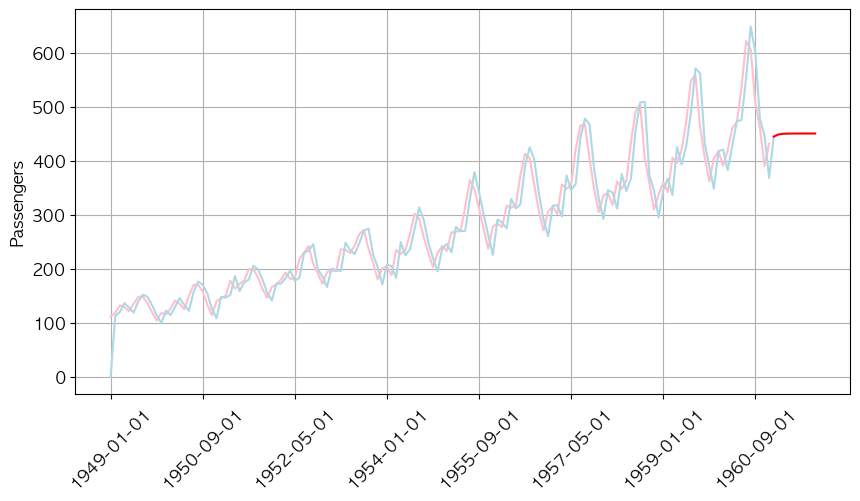

In [58]:
# x_ticks 라벨 생성
x = list(range(0, len(df), 20))
xlabels = []
for i in x:
    xlabels.append(df.loc[i, 'Month'].strftime('%Y-%m-%d'))
print(xlabels)

plt.figure()
sb.lineplot(x=df.index, y=df['Passengers'], color='pink') # 원본
sb.lineplot(x=pd.index, y=pd, color='lightblue')          # 원본을 토대로 학습하여 예측한 값
sb.lineplot(x=fc.index, y=fc, color = 'red')              # 이후 10단계를 예측한 값
plt.xticks(x, xlabels, rotation=45)
plt.grid()
plt.show()
plt.close()

## 5. Auto ARIMA
- `최적의 ARIMA 모델을 자동으로 찾아서 검색을 수행`해 주는 기능

### 1) 원본 데이터에 대한 분석 수행
- 예제 데이터에서는 파라미터를 변경하여 수행한 결과와 기본값만으로 수행한 결과가 동일하였다

In [53]:
model_aa = auto_arima(x=df['Passengers'],
                      y=df['Month'],
                      d=1,                     # 차분 횟수 (default=1)
                      start_p=1,               # (default=2)
                      max_p=3,                 # (default=5)
                      start_q=1,               # default=2
                      max_q=3,                 # default=5
                      seasonal=True,           # 계절성 고려 여부 (default=True)
                      trace=True,              # 자동으로 ARIMA 모델을 찾는 *과정* 출력 -> (1,1,1),(0,1,0),(1,1,0)...
                      error_action='ignore',   # error 발생하면 무시
                      suppress_warnings=True   # 경고 무시
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9529.255, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76478.633, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9534.927, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10562.511, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.108 seconds


> Best model(최적의 모델): `ARIMA(0,1,0)(0,0,0)[0]` 으로 확인

### 2) 분석 결과 확인

In [48]:
print(model_aa.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4762.628
Date:                Thu, 03 Aug 2023   AIC                           9529.255
Time:                        15:26:57   BIC                           9535.181
Sample:                             0   HQIC                          9531.663
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.629e+15   5.89e+12    446.227      0.000    2.62e+15    2.64e+15
sigma2      4.965e+27      0.069   7.23e+28      0.000    4.97e+27    4.97e+27
Ljung-Box (L1) (Q):                  33.61   Jarque-

### 3) 분석 결과에 대한 학습 및 예측값 시각화

144   -2.840457e+17
145   -2.814163e+17
146   -2.787868e+17
147   -2.761574e+17
148   -2.735279e+17
149   -2.708984e+17
150   -2.682690e+17
151   -2.656395e+17
152   -2.630101e+17
153   -2.603806e+17
dtype: float64
144    444.875121
145    448.821995
146    450.031912
147    450.402812
148    450.516512
149    450.551367
150    450.562051
151    450.565327
152    450.566331
153    450.566639
Name: predicted_mean, dtype: float64


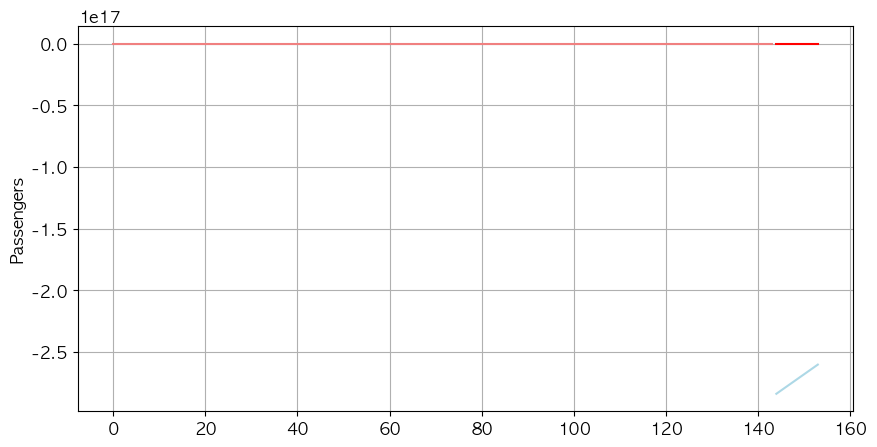

In [59]:
### 강사님 git엔 아래의 내용 없음, 내가 한 것임

# 학습 결과에 대한 예측값
start_index_aa = 0
end_index_aa = len(df['Passengers'])
pd_aa = model_aa.predict(start=start_index_aa, end=end_index_aa)
print(pd_aa)

# 이후 10단계를 예측한 값
fc_aa = fit.forecast(10)
print(fc_aa)

# 시각화
plt.figure()
sb.lineplot(x=df.index, y=df['Passengers'], color='lightcoral') # 원본
sb.lineplot(x=pd_aa.index, y=pd_aa, color='lightblue')          # 원본을 토대로 학습하여 예측한 값
sb.lineplot(x=fc_aa.index, y=fc_aa, color = 'red')              # 이후 10단계를 예측한 값

plt.grid()
plt.show()
plt.close()